In [133]:
import os
import sys
import json
import seaborn as sns
import numpy as np
import pandas as pd
from loguru import logger as log
from dtaidistance import dtw_visualisation as dtwvis

In [134]:
# Custom packages
from sediment_dtw import *
from utils import convert_warp_path_to_timeseries
from plotting import create_graph

In [135]:
log.remove()
log.add(sys.stderr, level="DEBUG");

In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define initial parameters

For example, if biostratigraphic data indicates that the age of oldest sediments in the core cannot exceed 245,000 years, set the `max_age` variable to 245. Similarly, set the `min_age` variable to the minimum age you expect the core top to be. For piston core from the ocean bottom, it is a good idea to set this to 0, but if data is available, such as for example the topmost 10k years are missing, this variable can be set to start at something else than 0. 

In [137]:
min_age = 0  # in kiloyears (kyrs) before present
max_age = 600 # in kiloyears (kyrs) before present
time_step = 5  # in kiloyears

### Find best distance: LR04stack vs M74/4-1100

##### Run parameters

In [138]:
ref = "LR04stack"
ref_path = f'../data/{ref}.csv'
ref_cols = ['time', 'd18O']
names = ['1100']
variables = ['d18O', 'aragonite']

##### Load target (reference) data and limit by `min_age` and `max_age`

In [139]:
target = pd.read_csv(ref_path, usecols=ref_cols) 
target = target[target['time'] <= max_age]
target = target[target['time'] >= min_age]
target.head(2)

,time,d18O
0,0.0,3.23
1,1.0,3.23


##### Load data curve (unknown time interval)

In [140]:
data = pd.read_csv(f'../data/core_1100_d18O_pl.csv', skip_blank_lines=True)
data.head(2)

,depth_m,d18O_pl
0,0.01,-1.924
1,0.06,-2.673


##### Define DTW object

In [141]:
dtw = SedimentDTW(target=target, 
                  data=data, 
                  normalize=True, 
                  smooth=True, 
                  window_size=11, 
                  polynomial=3)

2023-04-02 19:49:22.995 | DEBUG    | sediment_dtw:__init__:91 - Time-warp object created successfully!


##### Find simple distance

In [142]:
simple_distance = dtw.simple_distance()
print(round(simple_distance, 2))

12.2


##### Find minimum distance iteratively

In [143]:
distance, time, min_distances = dtw.find_min_distance(min_age, max_age, time_step, warp_path=True)
print(f'Found minimum distance: {round(distance, 2)} at target time {time} kyrs')

Found minimum distance: 3.84 at target time 275 kyrs


Text(0, 0.5, 'Distance')

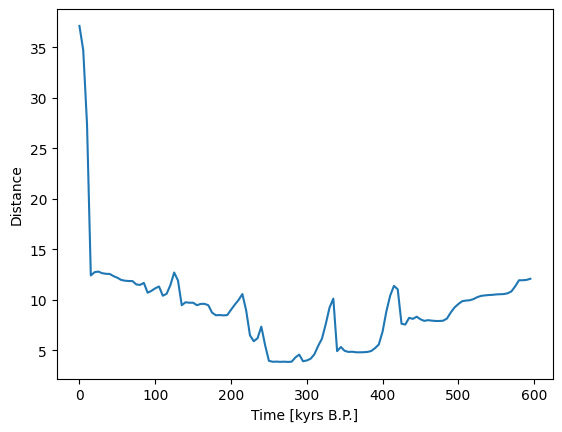

In [144]:
sns.lineplot(x=min_distances.keys(), y=min_distances.values(), data=min_distances)
plt.xlabel("Time [kyrs B.P.]")
plt.ylabel("Distance")

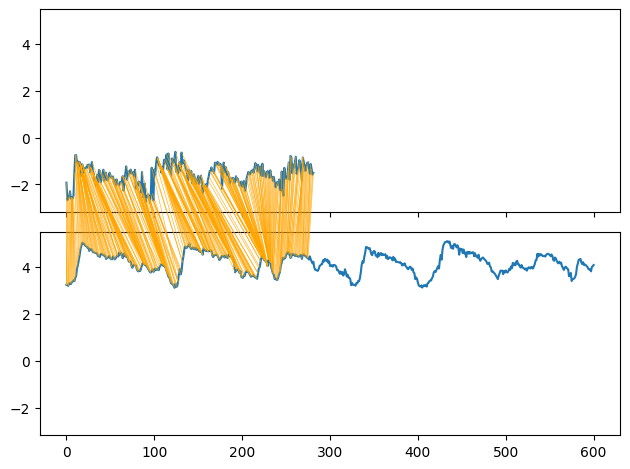

In [145]:
plot, ax = dtwvis.plot_warping(data.iloc[:,1], target.iloc[:,1], dtw.best_path)

In [146]:
plot.savefig("test.png")

In [147]:
dtw.best_path[:12]

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 1),
 (4, 2),
 (5, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (7, 7),
 (7, 8)]

In [148]:
def select_all_pairs(warp_path, index):
    pairs = list()
    for pair in warp_path:
        if pair[0] == index:
            pairs.append(pair)
    return pairs

In [149]:
def select_max_from_pairs(pairs):
    values = list()
    for pair in pairs:
        values.append(pair[1])
    return max(values)


In [150]:
def convert_warp_path_to_timeseries(target: Union[list, np.array, pd.Series], 
                                    data: Union[list, np.array, pd.Series],
                                    warp_path: list[tuple]):
    
    dtw_time_axis = list()
    for index, _ in enumerate(data):
        pairs = select_all_pairs(warp_path, index)
        maximum = select_max_from_pairs(pairs)
        dtw_time_axis.append(maximum)

    assert len(dtw_time_axis) == len(data)
    return dtw_time_axis

In [151]:
dtw_time_axis = convert_warp_path_to_timeseries(target['time'], data['depth_m'], dtw.best_path)

In [152]:
data['dtw_time [kyrs B.P.]'] = dtw_time_axis

In [153]:
data

,depth_m,d18O_pl,dtw_time [kyrs B.P.]
0,0.01,-1.924,0
1,0.06,-2.673,0
2,0.11,-2.551,0
3,0.16,-2.537,1
4,0.21,-2.290,2
...,...,...,...
277,13.96,-1.552,273
278,14.01,-1.132,274
279,14.06,-1.335,274
280,14.11,-1.585,274


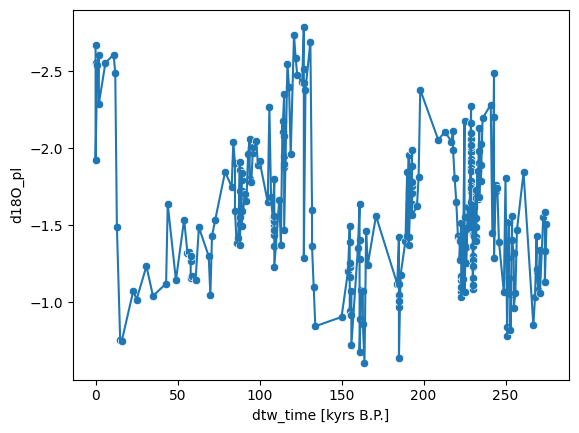

In [165]:
ax = sns.lineplot(x=data['dtw_time [kyrs B.P.]'], y=data['d18O_pl'], data=data, estimator=None)
ax = sns.scatterplot(x=data['dtw_time [kyrs B.P.]'], y=data['d18O_pl'], data=data)
ax.invert_yaxis()